# Import Library

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Data Scraping

In [2]:
# List ticker untuk saham 10 perusahaan Indonesia
tickers = ['BBCA.JK', 'BYAN.JK', 'TPIA.JK', 'BBRI.JK', 'BMRI.JK', 'DSSA.JK', 'TLKM.JK', 'ASII.JK', 'BBNI.JK', 'ICBP.JK']

# Download data harga penutupan (adjusted close) untuk setiap perusahaan dengan interval 1 hari
stock_close_datas = {}
stock_open_datas = {}
stock_high_datas = {}
stock_low_datas = {}
stock_volume_datas = {}
for ticker in tickers:
  df = yf.download(ticker, start='2018-01-01', end='2025-05-28', interval='1d')
  stock_open_datas[ticker] = df['Open']
  stock_high_datas[ticker] = df['High']
  stock_low_datas[ticker] = df['Low']
  stock_volume_datas[ticker] = df['Volume']
  stock_close_datas[ticker] = df['Close']

# Gabung semua jadi 1 dataframe
df_all = pd.concat(stock_close_datas, axis=1)
df_all.columns = tickers

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_all

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926025,711.824463,1457.917725,2289.992920,2592.610107,1390.0,3383.594238,5383.928223,3732.603271,7525.145020
2018-01-02,3723.926025,718.539856,1439.693848,2283.701904,2543.998535,1410.0,3360.732178,5319.062012,3685.475098,7694.249023
2018-01-03,3723.926025,718.539856,1403.245483,2271.118896,2495.386963,1390.0,3223.559082,5221.762695,3553.514404,7694.249023
2018-01-04,3779.189941,711.824463,1348.573853,2233.372070,2535.896484,1390.0,3215.938232,5335.278809,3544.088623,7715.386230
2018-01-05,3783.440674,715.182190,1385.021729,2258.536377,2535.896484,1390.0,3261.663330,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...
2025-05-21,9700.000000,19950.000000,9500.000000,4260.000000,5450.000000,50825.0,2750.000000,4670.000000,4520.000000,10825.000000
2025-05-22,9650.000000,19950.000000,9525.000000,4300.000000,5450.000000,51800.0,2800.000000,4630.000000,4470.000000,10800.000000
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


# Data Preprocessing

## Menangani Missing Value

In [4]:
df_all.isnull().sum()

BBCA.JK    0
BYAN.JK    0
TPIA.JK    0
BBRI.JK    0
BMRI.JK    0
DSSA.JK    0
TLKM.JK    1
ASII.JK    1
BBNI.JK    0
ICBP.JK    1
dtype: int64

In [56]:
# Melihat baris yang bernilai null
df_all[df_all.isnull().any(axis=1)]

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2019-06-19,5152.053223,1144.989868,1209.519775,2880.276367,2881.316895,1450.0,NaN,NaN,3534.166504,NaN


Melakukan Forward fill untuk mengisi data yang hilang pada `TLKM.JK`, `ASII.JK`, dan `ICBP.JK`

In [74]:
df_all_ffil = df_all.ffill()
display(df_all_ffil.loc["2019-06-18"])
display(df_all_ffil.loc["2019-06-19"])

BBCA.JK    5117.358887
BYAN.JK    1152.101685
TPIA.JK    1202.114380
BBRI.JK    2860.134277
BMRI.JK    2836.155029
DSSA.JK    1450.000000
TLKM.JK    3145.500732
ASII.JK    5101.784668
BBNI.JK    3464.674805
ICBP.JK    9077.743164
Name: 2019-06-18 00:00:00, dtype: float64

BBCA.JK    5152.053223
BYAN.JK    1144.989868
TPIA.JK    1209.519775
BBRI.JK    2880.276367
BMRI.JK    2881.316895
DSSA.JK    1450.000000
TLKM.JK    3145.500732
ASII.JK    5101.784668
BBNI.JK    3534.166504
ICBP.JK    9077.743164
Name: 2019-06-19 00:00:00, dtype: float64

In [75]:
df_all_ffil.shape

(1820, 10)

In [76]:
df_all_ffil.isnull().sum()

BBCA.JK    0
BYAN.JK    0
TPIA.JK    0
BBRI.JK    0
BMRI.JK    0
DSSA.JK    0
TLKM.JK    0
ASII.JK    0
BBNI.JK    0
ICBP.JK    0
dtype: int64

## Menangani Tanggal yang Terlewat dengan Forward Fill

Dilakukan Pengecekan terhadap berapa banyak hari yang tidak terdapat dalam data

In [77]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 884


Melakukan Forward Fill untuk mengisi tanggal yang hilang dengan cara menyebarkan data nilai terakhir yang diketahui ke depan hingga nilai berikutnya yang tidak hilang

In [78]:
df_all_ffil = df_all_ffil.reindex(full_date_range).ffill()
df_all_ffil.index.name = 'Date'
df_all_ffil

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926025,711.824463,1457.917725,2289.992920,2592.610107,1390.0,3383.594238,5383.928223,3732.603271,7525.145020
2018-01-02,3723.926025,718.539856,1439.693848,2283.701904,2543.998535,1410.0,3360.732178,5319.062012,3685.475098,7694.249023
2018-01-03,3723.926025,718.539856,1403.245483,2271.118896,2495.386963,1390.0,3223.559082,5221.762695,3553.514404,7694.249023
2018-01-04,3779.189941,711.824463,1348.573853,2233.372070,2535.896484,1390.0,3215.938232,5335.278809,3544.088623,7715.386230
2018-01-05,3783.440674,715.182190,1385.021729,2258.536377,2535.896484,1390.0,3261.663330,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


Melakukan pengecekan apakah tanggal yang hilang sudah berhasil diisi semuanya

In [79]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 0


## Mengganti Nama Kolom

In [80]:
df_all_ffil.columns = df_all_ffil.columns.str.replace('.JK', '', regex=False)
df_all_ffil

,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
Date,,,,,,,,,,
2018-01-01,3723.926025,711.824463,1457.917725,2289.992920,2592.610107,1390.0,3383.594238,5383.928223,3732.603271,7525.145020
2018-01-02,3723.926025,718.539856,1439.693848,2283.701904,2543.998535,1410.0,3360.732178,5319.062012,3685.475098,7694.249023
2018-01-03,3723.926025,718.539856,1403.245483,2271.118896,2495.386963,1390.0,3223.559082,5221.762695,3553.514404,7694.249023
2018-01-04,3779.189941,711.824463,1348.573853,2233.372070,2535.896484,1390.0,3215.938232,5335.278809,3544.088623,7715.386230
2018-01-05,3783.440674,715.182190,1385.021729,2258.536377,2535.896484,1390.0,3261.663330,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


## Menambah Fitur Tanggal

Dilakukan pengubahan data tanggal dari index menjadi kolom date

In [81]:
df_all_ffil = df_all_ffil.reset_index()
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926025,711.824463,1457.917725,2289.992920,2592.610107,1390.0,3383.594238,5383.928223,3732.603271,7525.145020
1,2018-01-02,3723.926025,718.539856,1439.693848,2283.701904,2543.998535,1410.0,3360.732178,5319.062012,3685.475098,7694.249023
2,2018-01-03,3723.926025,718.539856,1403.245483,2271.118896,2495.386963,1390.0,3223.559082,5221.762695,3553.514404,7694.249023
3,2018-01-04,3779.189941,711.824463,1348.573853,2233.372070,2535.896484,1390.0,3215.938232,5335.278809,3544.088623,7715.386230
4,2018-01-05,3783.440674,715.182190,1385.021729,2258.536377,2535.896484,1390.0,3261.663330,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


## Menangani Duplikasi Data

In [82]:
print("Jumlah duplikasi data:", df_all_ffil.duplicated().sum())

Jumlah duplikasi data: 0


## Mengurutkan data

Karena data yang dibutuhkan merupakan data time series, maka datanya harus berurutan berdasarkan waktu (Kolom `Date`)

In [83]:
df_all_ffil = df_all_ffil.sort_values(by="Date", ascending=True)
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926025,711.824463,1457.917725,2289.992920,2592.610107,1390.0,3383.594238,5383.928223,3732.603271,7525.145020
1,2018-01-02,3723.926025,718.539856,1439.693848,2283.701904,2543.998535,1410.0,3360.732178,5319.062012,3685.475098,7694.249023
2,2018-01-03,3723.926025,718.539856,1403.245483,2271.118896,2495.386963,1390.0,3223.559082,5221.762695,3553.514404,7694.249023
3,2018-01-04,3779.189941,711.824463,1348.573853,2233.372070,2535.896484,1390.0,3215.938232,5335.278809,3544.088623,7715.386230
4,2018-01-05,3783.440674,715.182190,1385.021729,2258.536377,2535.896484,1390.0,3261.663330,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


# Data Exploration

## Deskripsi Variabel

Setiap kolom berisi harga saham penutupan (adjusted close) dari top 20 emiten Indonesia

In [84]:
df_all_ffil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2704 non-null   datetime64[ns]
 1   BBCA    2704 non-null   float64       
 2   BYAN    2704 non-null   float64       
 3   TPIA    2704 non-null   float64       
 4   BBRI    2704 non-null   float64       
 5   BMRI    2704 non-null   float64       
 6   DSSA    2704 non-null   float64       
 7   TLKM    2704 non-null   float64       
 8   ASII    2704 non-null   float64       
 9   BBNI    2704 non-null   float64       
 10  ICBP    2704 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 232.5 KB


Terdapat nilai null pada beberapa kolom

In [85]:
df_all_ffil.describe()

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
count,2704,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000
mean,2021-09-13 12:00:00,6647.044796,7464.078752,3075.294015,3323.686707,3496.613425,7859.921413,3128.445691,4521.508766,3383.968305,9258.538805
min,2018-01-01 00:00:00,3529.552490,587.591003,1093.920776,1513.757080,1411.886963,920.000000,2070.656250,2251.151367,1292.781494,6683.180664
25%,2019-11-07 18:00:00,5111.656250,1156.325073,1722.659424,2546.368896,2476.076416,1497.500000,2766.273621,4184.783325,2789.609131,8028.596191
50%,2021-09-13 12:00:00,6205.837891,1422.347778,2247.613892,3233.821411,2806.314453,2212.500000,3029.644897,4564.072754,3421.679932,9129.916992
75%,2023-07-21 06:00:00,8451.990234,17674.641113,2599.425293,3979.260803,4483.701416,5000.000000,3534.067383,4890.241211,3988.643799,10396.153320
max,2025-05-27 00:00:00,10570.414062,22388.601562,10625.000000,5763.100098,6769.004883,53900.000000,4295.701172,5738.722656,5460.848145,12800.000000
std,NaN,1897.875954,7963.274613,2358.763384,936.935361,1349.876991,12444.669658,471.635289,633.273782,899.857008,1393.909426


## Analisis Harga Saham Tiap Perusahaan

In [86]:
dates = df_all_ffil['Date']
stocks = df_all_ffil.drop(columns='Date')

<Figure size 1400x600 with 0 Axes>

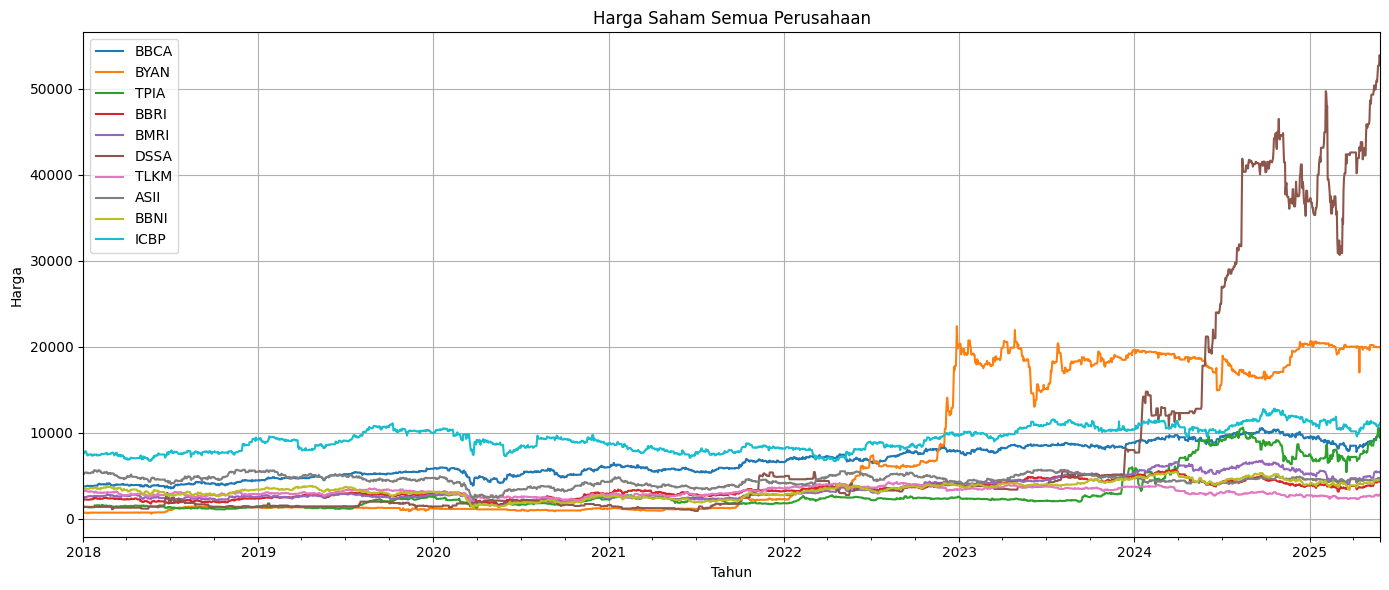

In [87]:
plt.figure(figsize=(14, 6))
stocks.index = dates  # ubah dates jadi index
stocks.plot(figsize=(14, 6))
plt.ylabel("Harga")
plt.xlabel("Tahun")
plt.title("Harga Saham Semua Perusahaan")
plt.grid(True)
plt.tight_layout()
plt.show()

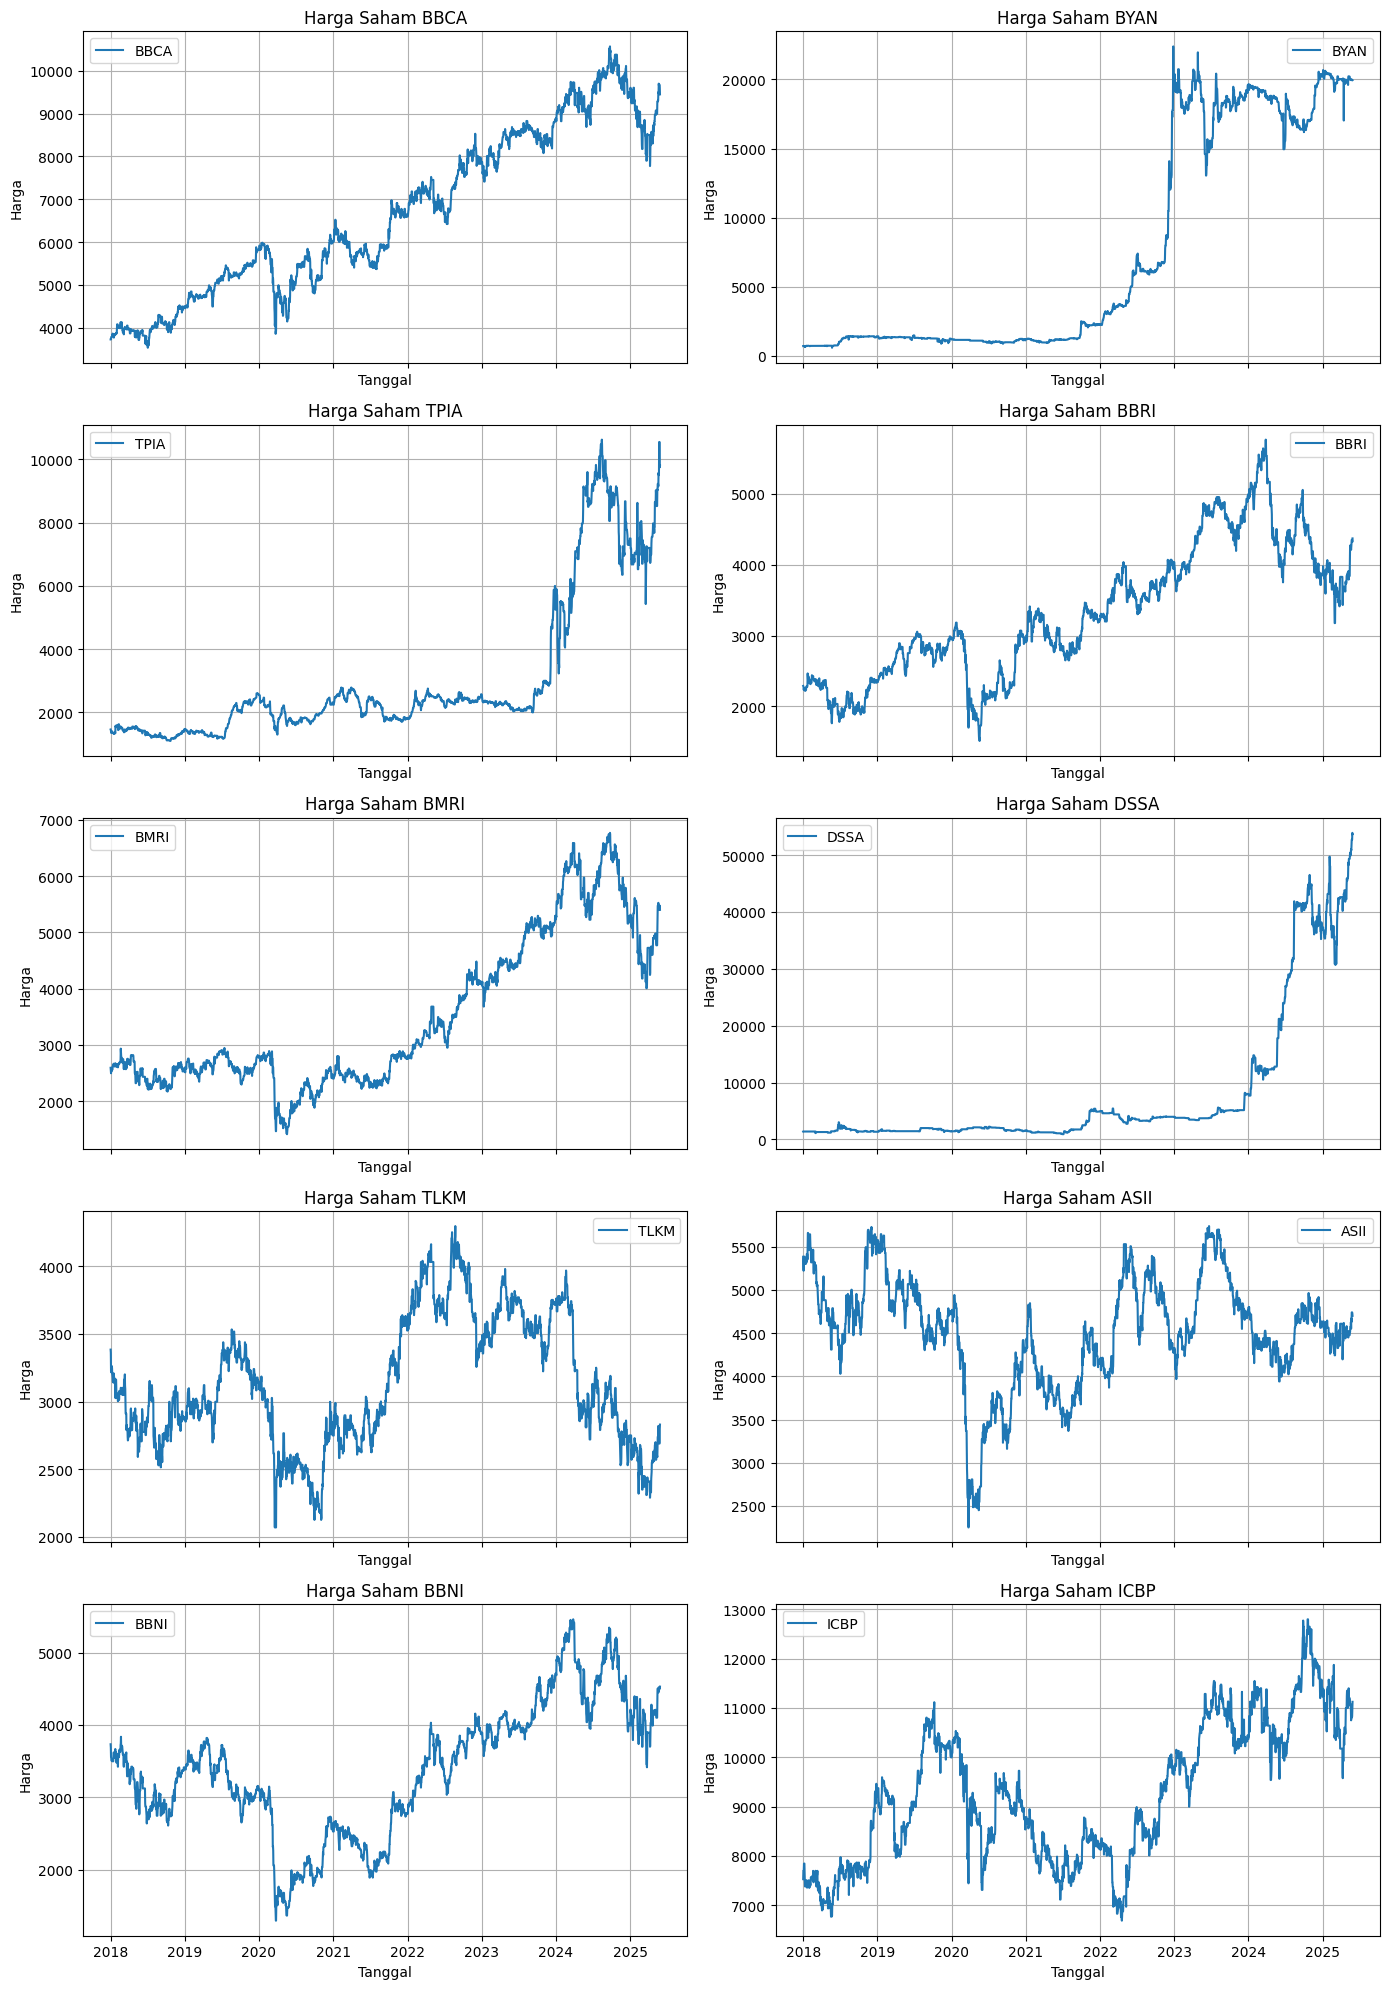

In [88]:
num_stocks = len(stocks.columns)
cols = 2  # jumlah kolom subplot
rows = (num_stocks + cols - 1) // cols  # jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()  # ubah axes jadi array datar agar mudah diakses

for i, stock in enumerate(stocks.columns):
    axes[i].plot(dates, stocks[stock], label=stock)
    axes[i].set_title(f"Harga Saham {stock}")
    axes[i].set_ylabel("Harga")
    axes[i].set_xlabel("Tanggal")
    axes[i].legend()
    axes[i].grid(True)

# Sembunyikan subplot kosong jika jumlah saham ganjil
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Korelasi Antar Saham

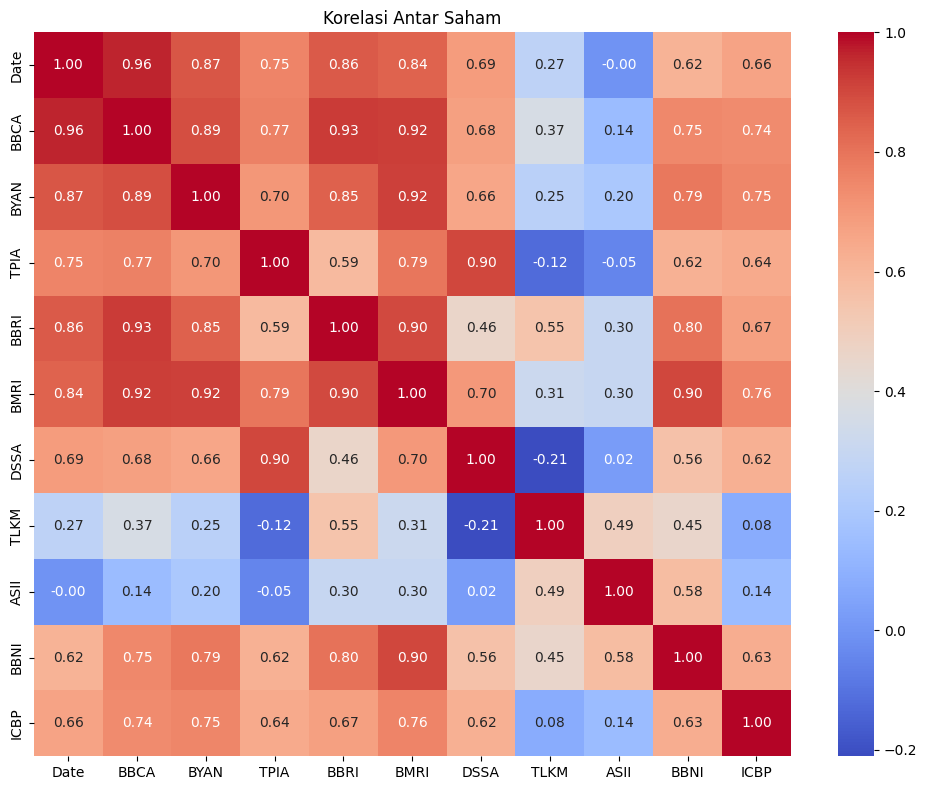

In [89]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_all_ffil.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Saham")
plt.tight_layout()
plt.show()

# Data Preparation

## Simpan Data ke Format CSV

In [90]:
# Saving data to csv
df_all_ffil.to_csv("stocks.csv", index=False)

## Normalisasi Data

In [91]:
scalers = {}
standardized_stocks = {}

for symbol, series in df_all_ffil.items():
    scaler = StandardScaler()
    series = series.values.reshape(-1, 1)  # Ensure 2D for scaler
    standardized = scaler.fit_transform(series)
    scalers[symbol] = scaler
    standardized_stocks[symbol] = standardized.squeeze()  # Back to 1D

## Windowing

In [92]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [93]:
combined_ds = None
for symbol, series in standardized_stocks.items():
    ds = windowed_dataset(series, window_size=30, batch_size=32, shuffle_buffer=1000)
    combined_ds = ds if combined_ds is None else combined_ds.concatenate(ds)

# Modeling